In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install Requirement**

In [ ]:
!pip install anomalib
!pip install anomalib[full]
!pip uninstall -y ollama
!pip install ollama==0.1.9
!pip install -U anomalib[full]
!pip install anomalib[full]
!pip install qdrant-client
!pip uninstall -y wandb
!pip install wandb==0.15.10
!pip install matplotlib==3.5.3

**Download Dataset**

In [ ]:
import torch
import requests, tarfile
from pathlib import Path
from tqdm import tqdm
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import EfficientAd, Patchcore

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
categories = ["grid", "tile", "leather"]

def download_data(root, filename, url):
    root.mkdir(parents=True, exist_ok=True)
    response = requests.get(url, stream=True)
    with open(root / filename, "wb") as file, tqdm(total=int(response.headers.get("content-length", 0)), unit="iB", unit_scale=True) as bar:
        for data in response.iter_content(1024):
            bar.update(len(data))
            file.write(data)
    with tarfile.open(root / filename, "r:gz") as tar:
        tar.extractall(path=root)
dataset_path = Path("./datasets/imagenette")
download_data(dataset_path, filename="imagenette2.tgz", url="https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz")



**Train EfficientAD Model**

In [8]:
import torch
import matplotlib.pyplot as plt
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import EfficientAd
import os

os.makedirs("results", exist_ok=True)

def train_and_evaluate(category):
    data = MVTec(root="./drive/MyDrive/content/datasets/MVTec",
                 category=category, train_batch_size=1, eval_batch_size=32, num_workers=8)

    model = EfficientAd()
    engine = Engine(max_epochs=5)

    engine.fit(datamodule=data, model=model)
    engine.test(datamodule=data, model=model)

    metrics = engine.trainer.callback_metrics
    img_auroc = metrics.get("image_AUROC", torch.tensor(0.0)).item()
    img_f1 = metrics.get("image_F1Score", torch.tensor(0.0)).item()
    pxl_auroc = metrics.get("pixel_AUROC", torch.tensor(0.0)).item()
    pxl_f1 = metrics.get("pixel_F1Score", torch.tensor(0.0)).item()

    return category, img_auroc, img_f1, pxl_auroc, pxl_f1

categories = ["grid", "tile", "leather"]
results = [train_and_evaluate(cat) for cat in categories]

labels, img_auroc, img_f1, pxl_auroc, pxl_f1 = zip(*results)

fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(labels))

ax.bar(x, img_auroc, width=0.2, label="Image_AUROC", align='center')
ax.bar([i + 0.2 for i in x], img_f1, width=0.2, label="Image_F1Score", align='center')
ax.bar([i + 0.4 for i in x], pxl_auroc, width=0.2, label="Pixel_AUROC", align='center')
ax.bar([i + 0.6 for i in x], pxl_f1, width=0.2, label="Pixel_F1Score", align='center')

ax.set_xticks([i + 0.3 for i in x])
ax.set_xticklabels(labels)
ax.set_ylabel("Score")
ax.set_title("EfficientAd Performance Metrics")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("results/efficientad_metrics.png")
plt.close()

with open("results/efficientad_metrics.txt", "w") as f:
    f.write("Category\tImage_AUROC\tImage_F1Score\tPixel_AUROC\tPixel_F1Score\n")
    for i, cat in enumerate(labels):
        f.write(f"{cat}\t{img_auroc[i]:.4f}\t{img_f1[i]:.4f}\t{pxl_auroc[i]:.4f}\t{pxl_f1[i]:.4f}\n")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.11/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9832915663719177     │
│       image_F1Score       │    0.9821428656578064     │
│        pixel_AUROC        │    0.9111028909683228     │
│       pixel_F1Score       │    0.4635619521141052     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.11/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.98124098777771      │
│       image_F1Score       │    0.9575757384300232     │
│        pixel_AUROC        │     0.830346941947937     │
│       pixel_F1Score       │    0.5852527618408203     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/anomalib/models/image/efficient_ad/lightning_model.py:98: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/usr/local/lib/python3.11/dist-packages/torchv

Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Validation: |          | 0/? [00:00<?, ?it/s]

Calculate Validation Dataset Quantiles: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.86548912525177      │
│       image_F1Score       │    0.8648648858070374     │
│        pixel_AUROC        │    0.9357349276542664     │
│       pixel_F1Score       │    0.4197283387184143     │
└───────────────────────────┴───────────────────────────┘

**Train PatchCore Model**

In [7]:
import torch
import matplotlib.pyplot as plt
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import Patchcore
import os

os.makedirs("results", exist_ok=True)

def train_and_evaluate(category):
    data = MVTec(root="./drive/MyDrive/content/datasets/MVTec",
                 category=category, train_batch_size=1, eval_batch_size=4, num_workers=2)

    model = Patchcore(backbone="resnet18", layers=["layer2", "layer3", "layer4"], pre_trained=False, num_neighbors=3)
    engine = Engine(max_epochs=3)

    engine.fit(datamodule=data, model=model)
    engine.test(datamodule=data, model=model)

    metrics = engine.trainer.callback_metrics
    img_auroc = metrics.get("image_AUROC", torch.tensor(0.0)).item()
    img_f1 = metrics.get("image_F1Score", torch.tensor(0.0)).item()
    pxl_auroc = metrics.get("pixel_AUROC", torch.tensor(0.0)).item()
    pxl_f1 = metrics.get("pixel_F1Score", torch.tensor(0.0)).item()

    return category, img_auroc, img_f1, pxl_auroc, pxl_f1

categories = ["grid", "tile", "leather"]
results = [train_and_evaluate(cat) for cat in categories]

labels, img_auroc, img_f1, pxl_auroc, pxl_f1 = zip(*results)

fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(labels))

ax.bar(x, img_auroc, width=0.2, label="Image_AUROC", align='center')
ax.bar([i + 0.2 for i in x], img_f1, width=0.2, label="Image_F1Score", align='center')
ax.bar([i + 0.4 for i in x], pxl_auroc, width=0.2, label="Pixel_AUROC", align='center')
ax.bar([i + 0.6 for i in x], pxl_f1, width=0.2, label="Pixel_F1Score", align='center')

ax.set_xticks([i + 0.3 for i in x])
ax.set_xticklabels(labels)
ax.set_ylabel("Score")
ax.set_title("PatchCore Performance Metrics")
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("results/patchcore_metrics.png")
plt.close()

with open("results/patchcore_metrics.txt", "w") as f:
    f.write("Category\tImage_AUROC\tImage_F1Score\tPixel_AUROC\tPixel_F1Score\n")
    for i, cat in enumerate(labels):
        f.write(f"{cat}\t{img_auroc[i]:.4f}\t{img_f1[i]:.4f}\t{pxl_auroc[i]:.4f}\t{pxl_f1[i]:.4f}\n")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 11.2 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/20697 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 84/20697 [00:00<00:24, 832.47it/s]

Selecting Coreset Indices.:   1%|          | 168/20697 [00:00<00:24, 836.02it/s]

Selecting Coreset Indices.:   1%|          | 252/20697 [00:00<00:24, 832.41it/s]

Selecting Coreset Indices.:   2%|▏         | 341/20697 [00:00<00:23, 854.96it/s]

Selecting Coreset Indices.:   2%|▏         | 431/20697 [00:00<00:23, 869.81it/s]

Selecting Coreset Indices.:   3%|▎         | 522/20697 [00:00<00:22, 880.29it/s]

Selecting Coreset Indices.:   3%|▎         | 612/20697 [00:00<00:22, 884.66it/s]

Selecting Coreset Indices.:   3%|▎         | 701/20697 [00:00<00:22, 877.94it/s]

Selecting Coreset Indices.:   4%|▍         | 790/20697 [00:00<00:22, 878.88it/s]

Selecting Coreset Indices.:   4%|▍         | 879/20697 [00:01<00:22, 880.45it/s]

Selecting Coreset Indices.:   5%|▍         | 969/20697 [00:01<00:22, 884.02it/s]

Selecting Coreset Indices.

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9030910730361938     │
│       image_F1Score       │    0.9333333373069763     │
│        pixel_AUROC        │    0.7891731262207031     │
│       pixel_F1Score       │    0.13857124745845795    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 11.2 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/18032 [00:00<?, ?it/s]

Selecting Coreset Indices.:   1%|          | 93/18032 [00:00<00:19, 925.30it/s]

Selecting Coreset Indices.:   1%|          | 190/18032 [00:00<00:18, 947.70it/s]

Selecting Coreset Indices.:   2%|▏         | 288/18032 [00:00<00:18, 959.69it/s]

Selecting Coreset Indices.:   2%|▏         | 390/18032 [00:00<00:17, 980.54it/s]

Selecting Coreset Indices.:   3%|▎         | 490/18032 [00:00<00:17, 986.31it/s]

Selecting Coreset Indices.:   3%|▎         | 592/18032 [00:00<00:17, 996.04it/s]

Selecting Coreset Indices.:   4%|▍         | 694/18032 [00:00<00:17, 1002.28it/s]

Selecting Coreset Indices.:   4%|▍         | 795/18032 [00:00<00:17, 1004.29it/s]

Selecting Coreset Indices.:   5%|▍         | 897/18032 [00:00<00:17, 1006.80it/s]

Selecting Coreset Indices.:   6%|▌         | 999/18032 [00:01<00:16, 1010.82it/s]

Selecting Coreset Indices.:   6%|▌         | 1101/18032 [00:01<00:16, 1011.38it/s]

Selecting Coreset In

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9466089606285095     │
│       image_F1Score       │    0.9308176040649414     │
│        pixel_AUROC        │    0.8602414727210999     │
│       pixel_F1Score       │    0.5740624666213989     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | PatchcoreModel           | 11.2 M | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metric

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/19208 [00:00<?, ?it/s]

Selecting Coreset Indices.:   0%|          | 89/19208 [00:00<00:21, 887.36it/s]

Selecting Coreset Indices.:   1%|          | 185/19208 [00:00<00:20, 928.70it/s]

Selecting Coreset Indices.:   1%|▏         | 282/19208 [00:00<00:19, 946.32it/s]

Selecting Coreset Indices.:   2%|▏         | 379/19208 [00:00<00:19, 955.42it/s]

Selecting Coreset Indices.:   2%|▏         | 477/19208 [00:00<00:19, 961.93it/s]

Selecting Coreset Indices.:   3%|▎         | 575/19208 [00:00<00:19, 965.94it/s]

Selecting Coreset Indices.:   4%|▎         | 674/19208 [00:00<00:19, 970.67it/s]

Selecting Coreset Indices.:   4%|▍         | 772/19208 [00:00<00:19, 970.20it/s]

Selecting Coreset Indices.:   5%|▍         | 870/19208 [00:00<00:18, 973.19it/s]

Selecting Coreset Indices.:   5%|▌         | 969/19208 [00:01<00:18, 975.69it/s]

Selecting Coreset Indices.:   6%|▌         | 1067/19208 [00:01<00:18, 975.91it/s]

Selecting Coreset Indices

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8756793141365051     │
│       image_F1Score       │    0.8633880019187927     │
│        pixel_AUROC        │    0.9635077118873596     │
│       pixel_F1Score       │    0.36189067363739014    │
└───────────────────────────┴───────────────────────────┘

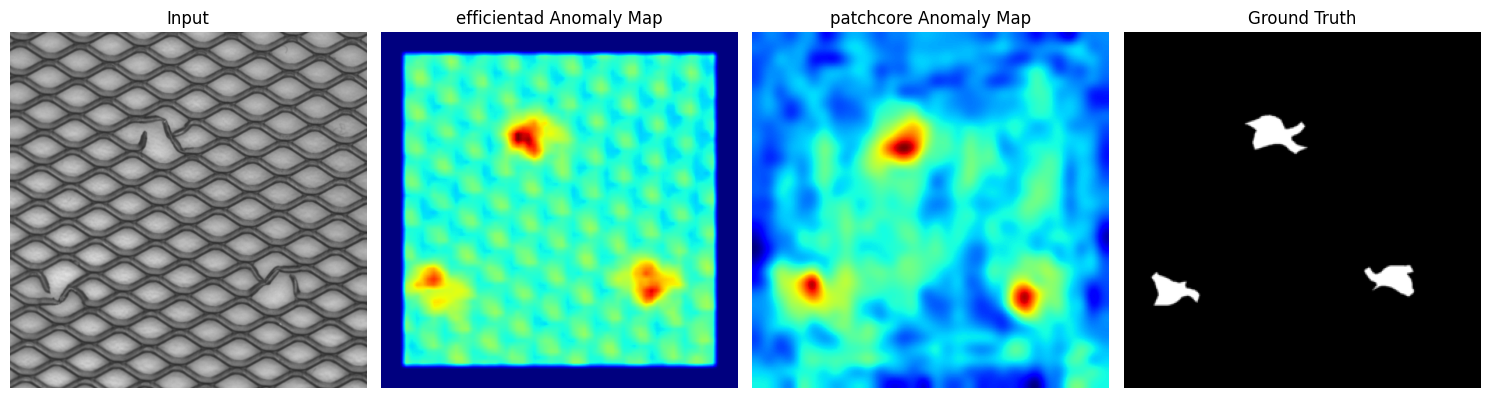

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from anomalib.models import EfficientAd, Patchcore
from torchvision import transforms
from PIL import Image
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

models = {
    "efficientad": EfficientAd.load_from_checkpoint("/content/drive/MyDrive/content/results/EfficientAd/MVTec/grid/latest/weights/lightning/model.ckpt").eval().to(device),
    "patchcore": Patchcore.load_from_checkpoint("/content/drive/MyDrive/content/results/Patchcore/MVTec/grid/latest/weights/lightning/model.ckpt").eval().to(device)
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def get_map(model, path):
    img = transform(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img)
    key = next((k for k in ["anomaly_map", "map_st", "map_ae"] if k in out), None)
    return out[key].squeeze().cpu().numpy() if key else None

def load_mask(path):
    return np.array(transforms.Resize((256, 256))(Image.open(path).convert("L"))) if os.path.exists(path) else None

def show_results(img_path, maps, mask=None):
    img = Image.open(img_path).convert("RGB")
    fig, axes = plt.subplots(1, len(maps) + (1 if mask is not None else 0) + 1, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title("Input")
    axes[0].axis("off")

    for i, (name, anomaly_map) in enumerate(maps.items(), 1):
        axes[i].imshow(anomaly_map, cmap="jet")
        axes[i].set_title(f"{name} Anomaly Map")
        axes[i].axis("off")

    if mask is not None:
        axes[-1].imshow(mask, cmap="gray")
        axes[-1].set_title("Ground Truth")
        axes[-1].axis("off")

    plt.tight_layout()
    plt.show()

img_path = "/content/drive/MyDrive/content/datasets/MVTec/grid/test/broken/001.png"
mask_path = "/content/drive/MyDrive/content/datasets/MVTec/grid/ground_truth/broken/001_mask.png"

maps = {name: get_map(model, img_path) for name, model in models.items()}
mask = load_mask(mask_path)

show_results(img_path, maps, mask)

In [10]:
!zip -r results.zip /content/results/
from google.colab import files
files.download("results.zip")

Streaming output truncated to the last 5000 lines.
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/007_4.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/010_4.png (deflated 5%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/003.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/012_3.png (deflated 5%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/001_2.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/001_1.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/028_4.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/025_4.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/031_2.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/030_3.png (deflated 6%)
  adding: content/results/Patchcore/MVTec/tile/v1/images/good/006_1.png (deflated 6%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.cuda.empty_cache()

**Similarity Search**

In [46]:
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, Distance, VectorParams, Filter, FieldCondition
from anomalib.models import EfficientAd
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

path = "/content/results/EfficientAd/MVTec/grid/latest/weights/lightning/model.ckpt"
model = EfficientAd.load_from_checkpoint(path).eval().to(device)

preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(model, img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(tensor)

    key = next((k for k in ["map_st", "map_ae"] if k in out), None)
    fmap = out[key]
    features = F.adaptive_avg_pool2d(fmap, (1, 1)).view(-1).cpu().numpy()

    return np.pad(features, (0, max(0, 1024 - len(features))))[:1024] / np.linalg.norm(features)

client = QdrantClient(":memory:")
collection = "efficientad_grid"

if client.collection_exists(collection):
    client.delete_collection(collection)

client.create_collection(collection_name=collection, vectors_config=VectorParams(size=1024, distance=Distance.COSINE))

os.makedirs("results", exist_ok=True)

points, img_id = [], 0
data_dir = "/content/drive/MyDrive/content/datasets/MVTec/grid/test/"
for root, _, files in os.walk(data_dir):
    for f in files:
        if f.endswith((".png", ".jpg")):
            img_path = os.path.join(root, f)
            vector = extract_features(model, img_path)
            points.append(PointStruct(id=img_id, vector=vector.tolist(), payload={"img": img_path, "abn": "good" not in img_path}))
            img_id += 1
client.upsert(collection_name=collection, points=points)

query_path = "/content/drive/MyDrive/content/datasets/MVTec/grid/test/broken/000.png"
query_vector = extract_features(model, query_path)
abn = "good" not in query_path
query_filter = Filter(must=[FieldCondition(key="abn", match={"value": abn})])

results = client.search(collection_name=collection, query_vector=query_vector.tolist(), query_filter=query_filter, limit=5)
similar_paths = [hit.payload["img"] for hit in results]

fig, axes = plt.subplots(2, max(1, len(similar_paths)), figsize=(15, 6))
axes[0, 0].imshow(Image.open(query_path))
axes[0, 0].set_title("Query Image")
axes[0, 0].axis("off")

for i, img_path in enumerate(similar_paths):
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Similar {i+1}")
    axes[1, i].axis("off")

plt.savefig("results/EfficientAd_query_similar_images.png")
plt.close()

<ipython-input-46-9e507316e944>:62: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(collection_name=collection, query_vector=query_vector.tolist(), query_filter=query_filter, limit=5)


In [45]:
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, Distance, VectorParams, Filter, FieldCondition
from anomalib.models import Patchcore
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

path = "/content/results/Patchcore/MVTec/leather/latest/weights/lightning/model.ckpt"
model = Patchcore.load_from_checkpoint(path).eval().to(device)

preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(model, img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(tensor)

    if "anomaly_map" not in out:
        raise KeyError(f"Expected 'anomaly_map' in model output, but found {list(out.keys())}")

    fmap = out["anomaly_map"]
    features = F.adaptive_avg_pool2d(fmap, (1, 1)).view(-1).cpu().numpy()

    return np.pad(features, (0, max(0, 1024 - len(features))))[:1024] / np.linalg.norm(features)

client = QdrantClient(":memory:")
collection = "patchcore_leather"

if client.collection_exists(collection):
    client.delete_collection(collection)

client.create_collection(collection_name=collection, vectors_config=VectorParams(size=1024, distance=Distance.COSINE))

os.makedirs("results", exist_ok=True)

points, img_id = [], 0
data_dir = "/content/drive/MyDrive/content/datasets/MVTec/leather/test/"
for root, _, files in os.walk(data_dir):
    for f in files:
        if f.endswith((".png", ".jpg")):
            img_path = os.path.join(root, f)
            vector = extract_features(model, img_path)
            points.append(PointStruct(id=img_id, vector=vector.tolist(), payload={"img": img_path, "abn": "good" not in img_path}))
            img_id += 1
client.upsert(collection_name=collection, points=points)

query_path = "/content/drive/MyDrive/content/datasets/MVTec/leather/test/good/000.png"
query_vector = extract_features(model, query_path)
abn = "good" not in query_path
query_filter = Filter(must=[FieldCondition(key="abn", match={"value": abn})])

results = client.search(collection_name=collection, query_vector=query_vector.tolist(), query_filter=query_filter, limit=5)
similar_paths = [hit.payload["img"] for hit in results]

fig, axes = plt.subplots(2, max(1, len(similar_paths)), figsize=(15, 6))
axes[0, 0].imshow(Image.open(query_path))
axes[0, 0].set_title("Query Image")
axes[0, 0].axis("off")

for i, img_path in enumerate(similar_paths):
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Similar {i+1}")
    axes[1, i].axis("off")

plt.savefig("results/Patchcore_query_similar_images.png")
plt.close()



<ipython-input-45-b163b52d80d8>:64: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = client.search(collection_name=collection, query_vector=query_vector.tolist(), query_filter=query_filter, limit=5)


**Patch Description Network (PDN) Receptive Field Calculation**

In [76]:
from anomalib.models import EfficientAd

# 获取模型的参数
print(EfficientAd.__doc__)  # 查看 EfficientAd 的文档


PL Lightning Module for the EfficientAd algorithm.

    Args:
        imagenet_dir (Path|str): directory path for the Imagenet dataset
            Defaults to ``./datasets/imagenette``.
        teacher_out_channels (int): number of convolution output channels
            Defaults to ``384``.
        model_size (str): size of student and teacher model
            Defaults to ``EfficientAdModelSize.S``.
        lr (float): learning rate
            Defaults to ``0.0001``.
        weight_decay (float): optimizer weight decay
            Defaults to ``0.00001``.
        padding (bool): use padding in convoluional layers
            Defaults to ``False``.
        pad_maps (bool): relevant if padding is set to False. In this case, pad_maps = True pads the
            output anomaly maps so that their size matches the size in the padding = True case.
            Defaults to ``True``.
    


In [92]:
from anomalib.models import EfficientAd
model = EfficientAd(
    teacher_out_channels=384,
    padding=True,
)
print(model)

EfficientAd(
  (model): EfficientAdModel(
    (teacher): SmallPatchDescriptionNetwork(
      (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
      (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(256, 384, kernel_size=(4, 4), stride=(1, 1))
      (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
      (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    )
    (student): SmallPatchDescriptionNetwork(
      (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
      (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
      (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv4): Conv2d(256, 768, kernel_size=(4, 4), stride=(1, 1))
      (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
      (avgpool2): AvgPool2d(kernel_size=2,